#Import statements


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import scipy.stats as stats
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import StratifiedKFold
plt.style.use('seaborn')
np.random.seed(1234)
pd.options.mode.chained_assignment = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)


df_raw = pd.read_csv('/content/drive/My Drive/Modello_Ex_Ante/dataframe_ready_1').drop(['Unnamed: 0', 'offerta_minima', 'procedura_tipologia'], axis = 1)

df_raw['data_asta'] = lookup(df_raw['data_asta'])


In [ ]:
df_raw.head(10)

,id,categoria,regione,provincia,comune,data_aggiudicata,data_asta,prezzo_base,numero_esperimento,esito,offmin
0,b1607915,Immobile Residenziale,Veneto,Verona,Veronella,2019-02-07,2019-02-07,123000.0,1,1,92250.0
1,b1608071,Immobile Commerciale,Veneto,Vicenza,Trissino,2019-03-06,2019-03-06,337500.0,6,0,253125.0
2,b1608110,Immobile Residenziale,Veneto,Vicenza,Vicenza,2019-03-06,2019-03-06,57800.0,1,1,43350.0
3,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2018-09-20,500000.0,1,0,375000.0
4,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2018-11-22,375000.0,2,0,281250.0
5,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2019-02-14,282000.0,3,1,211500.0
6,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-04-11,60000.0,1,0,45000.0
7,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-07-10,45000.0,2,0,33750.0
8,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-11-08,33750.0,3,0,25312.5
9,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2019-03-20,25320.0,4,1,18990.0


## Adding Sconto Prezzo Base

In [ ]:
sconto = df_raw.groupby('id')['prezzo_base'].apply(lambda x: (x.loc[x.index.tolist()[0]] - x) / x.loc[x.index.tolist()[0]])
df_raw.sort_values(['id', 'numero_esperimento'], inplace = True)
df_raw['sconto'] = sconto
df_raw.reset_index(drop=True, inplace=True)

In [ ]:
df_raw.head(10)

,id,categoria,regione,provincia,comune,data_aggiudicata,data_asta,prezzo_base,numero_esperimento,esito,offmin,sconto
0,b1607915,Immobile Residenziale,Veneto,Verona,Veronella,2019-02-07,2019-02-07,123000.0,1,1,92250.0,0.0000
1,b1608071,Immobile Commerciale,Veneto,Vicenza,Trissino,2019-03-06,2019-03-06,337500.0,6,0,253125.0,0.0000
2,b1608110,Immobile Residenziale,Veneto,Vicenza,Vicenza,2019-03-06,2019-03-06,57800.0,1,1,43350.0,0.0000
3,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2018-09-20,500000.0,1,0,375000.0,0.0000
4,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2018-11-22,375000.0,2,0,281250.0,0.2500
5,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2019-02-14,282000.0,3,1,211500.0,0.4360
6,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-04-11,60000.0,1,0,45000.0,0.0000
7,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-07-10,45000.0,2,0,33750.0,0.2500
8,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-11-08,33750.0,3,0,25312.5,0.4375
9,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2019-03-20,25320.0,4,1,18990.0,0.5780


## Adding Sconto Offerta Minima

In [ ]:
sconto_offmin = df_raw.groupby('id')[['prezzo_base', 'offmin']].apply(lambda x: ((x['prezzo_base'].loc[x.index.tolist()[0]] - x['offmin']) / x['prezzo_base'].loc[x.index.tolist()[0]]).to_frame('new'))
df_raw.sort_values(['id', 'numero_esperimento'], inplace = True)
df_raw['sconto_offmin'] = sconto_offmin
df_raw.reset_index(drop=True, inplace=True)

In [ ]:
df_raw.head(10)

,id,categoria,regione,provincia,comune,data_aggiudicata,data_asta,prezzo_base,numero_esperimento,esito,offmin,sconto,sconto_offmin
0,b1607915,Immobile Residenziale,Veneto,Verona,Veronella,2019-02-07,2019-02-07,123000.0,1,1,92250.0,0.0000,0.250000
1,b1608071,Immobile Commerciale,Veneto,Vicenza,Trissino,2019-03-06,2019-03-06,337500.0,6,0,253125.0,0.0000,0.250000
2,b1608110,Immobile Residenziale,Veneto,Vicenza,Vicenza,2019-03-06,2019-03-06,57800.0,1,1,43350.0,0.0000,0.250000
3,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2018-09-20,500000.0,1,0,375000.0,0.0000,0.250000
4,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2018-11-22,375000.0,2,0,281250.0,0.2500,0.437500
5,b1608523,Immobile Commerciale,Veneto,Verona,Verona,2019-02-14,2019-02-14,282000.0,3,1,211500.0,0.4360,0.577000
6,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-04-11,60000.0,1,0,45000.0,0.0000,0.250000
7,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-07-10,45000.0,2,0,33750.0,0.2500,0.437500
8,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2018-11-08,33750.0,3,0,25312.5,0.4375,0.578125
9,b1610910,Immobile Residenziale,Veneto,Vicenza,Barbarano Vicentino,2019-03-20,2019-03-20,25320.0,4,1,18990.0,0.5780,0.683500


In [ ]:
df_raw = df_raw[df_raw['sconto_offmin'] >= 0]


##Adding NTN

In [ ]:
lista_comuni = pd.read_csv('/content/drive/My Drive/Ntn/2018_LISTA-COM.csv', delimiter = ';', header = None, names = ['zona', 'regione', 'provincia', 'codice_comune', 'comune'], dtype = str)
res = pd.read_csv('/content/drive/My Drive/Ntn/2018_RES.csv', sep=';', header=None, names = ['zona', 'regione', 'provincia', 'codice_comune', 'ntn_tra_0_e_49_mq', 'ntn_tra_50_e_84_mq','ntn_tra_85_e_114_mq', 'ntn_tra_115_e_144_mq', 'ntn_da_145mq_in_su', 'ntn_totale'], dtype = str)
popolazione_comuni = pd.read_excel('/content/drive/My Drive/Ntn/Elenco-comuni-italiani.xls', usecols = [18, 19], names = ['codice_comune', 'abitanti'])

In [ ]:
# transfrom commas in dots so that you can transform in float and do it
columns_with_commas = ['ntn_tra_0_e_49_mq', 'ntn_tra_50_e_84_mq','ntn_tra_85_e_114_mq', 'ntn_tra_115_e_144_mq', 'ntn_da_145mq_in_su', 'ntn_totale']
res[columns_with_commas] = res.loc[:, columns_with_commas].applymap(lambda x: pd.to_numeric(x.replace(',', '.')))

# merge the two and keep only comune and its ntn_totale
print(res.shape, lista_comuni.shape)
ntn = res.merge(lista_comuni, on = ['codice_comune', 'zona', 'provincia', 'regione'])
print(ntn.shape)

ntn = ntn.merge(popolazione_comuni, how = 'inner', on = ['codice_comune'])
print(ntn.shape)

# dropping useless columns
ntn['comune'] = ntn['comune'].str.upper()
ntn = ntn[['abitanti', 'comune', 'ntn_totale', 'regione']]
ntn.head()

(7603, 10) (7604, 5)
(7602, 11)
(7538, 12)


,abitanti,comune,ntn_totale,regione
0,19349,ABANO TERME,291.49,Veneto
1,297,ABBADIA CERRETO,1.00,Lombardia
2,3249,ABBADIA LARIANA,37.96,Lombardia
3,6557,ABBADIA SAN SALVATORE,91.25,Toscana
4,2828,ABBASANTA,12.00,Sardegna


Text(0.5, 0, 'NTN mean')

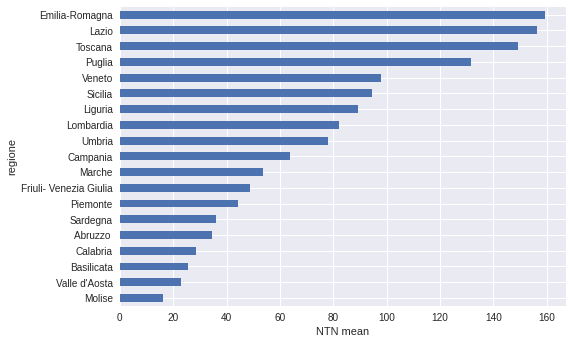

In [ ]:
ntn.groupby('regione')['ntn_totale'].mean().sort_values().plot.barh()
plt.xlabel('NTN mean')

Text(0.5, 0, 'Abitanti mean')

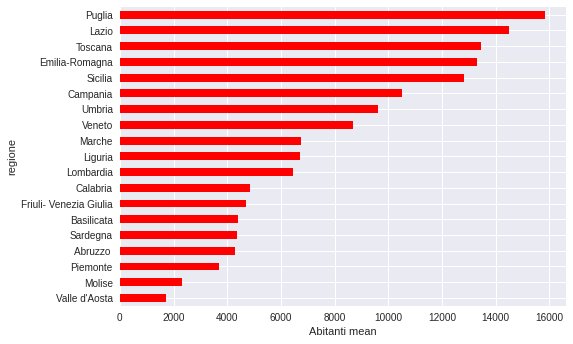

In [ ]:
ntn.groupby('regione')['abitanti'].mean().sort_values().plot.barh(color='r')
plt.xlabel('Abitanti mean')

##Merge NTN with DataFrame


In [ ]:
df_raw['comune'] = df_raw['comune'].str.upper()
df_raw = df_raw.merge(ntn.drop('regione', axis=1), how = 'left', on = ['comune'])
print('We have a total number of unmatched comune equal to:')
print(df_raw['ntn_totale'].isnull().sum())

We have a total number of unmatched comune equal to:
1387


###Clean and replace comune values for mismatchings


In [ ]:
df_raw['comune'].loc[df_raw['ntn_totale'].isnull()].value_counts().head(30)

CORIGLIANO CALABRO          89
TRENTO                      61
ROSSANO                     59
MUGGIÒ                      46
CASSANO ALL'IONIO           45
BOVISIO-MASCIAGO            38
CITTÀ DI CASTELLO           36
GORIZIA                     31
SORBOLO MEZZANI             26
CANTÙ                       25
BORGO VALSUGANA             25
MONFALCONE                  22
CAVEDINE                    21
VILLE D'ANAUNIA             20
RIVANAZZANO TERME           20
CLES                        18
MEZZOLOMBARDO               17
ZERBOLÒ                     17
STORO                       15
VALLELAGHI                  14
CEMBRA LISIGNAGO            14
MADRUZZO                    14
TRIESTE                     14
CAVAGLIÀ                    13
ALBIANO                     13
VERMIGLIO                   13
LAVIS                       12
PREDAIA                     11
SANSEPOLCRO                 11
TAVAZZANO CON VILLAVESCO    11
Name: comune, dtype: int64

In [ ]:
df_raw['comune'].replace({'CORIGLIANO CALABRO': 'CORIGLIANO-ROSSANO', 'ROSSANO': 'CORIGLIANO-ROSSANO',
                          'MUGGIÒ': "MUGGIO'", "CASSANO ALL'IONIO": "CASSANO ALLO IONIO", "BOVISIO-MASCIAGO":"BOVISIO MASCIAGO",
                          "CITTÀ DI CASTELLO": "CITTA' DI CASTELLO", "CANTÙ": "CANTU'", "RINAVAZZANO TERME":"RIVANAZZANO",
                          "ZERBOLÒ":"ZERBOLO", "CAVAGLIÀ":"CAVAGLIA", "TAVAZZANO CON VILLAVESCO": "TAVAZZANO VILLAVESCO",
                          "SANSEPOLCRO": "SAN SEPOLCRO"}, inplace=True)

df_raw = df_raw.drop(['abitanti', 'ntn_totale'], axis=1).merge(ntn.drop('regione', axis=1), how = 'left', on = ['comune'])
print('After recovering some towns, nulls are:')
print(df_raw['ntn_totale'].isnull().sum())

After recovering some towns, nulls are:
997


##Dummy for Experiment Number <= 5

In [ ]:
df_raw = df_raw[df_raw['numero_esperimento'] <= 6]

## Encode Categoria

In [ ]:
df_raw['categoria'] = df_raw['categoria'].map({'Immobile Commerciale': 0, 'Immobile Residenziale': 1})

#Printing Final Dataframe

In [ ]:
df = df_raw

In [ ]:
print(df.isnull().sum())
df.reset_index(drop=True, inplace=True)

id                      0
categoria               0
regione                 0
provincia               0
comune                  0
data_aggiudicata        0
data_asta               0
prezzo_base             0
numero_esperimento      0
esito                   0
offmin                  0
sconto                  0
sconto_offmin           0
abitanti              909
ntn_totale            909
dtype: int64


In [ ]:
df['esito'].value_counts()

0    8920
1    6104
Name: esito, dtype: int64

# EDA

## Space and Time

### Plotting Numero Aste Distribution by Regione and by Esito

In [ ]:
print('Numero aste per Regione e per Esito: ')
print(pd.crosstab(index=df_raw['esito'], columns=df_raw['regione']))

Numero aste per Regione e per Esito: 
regione  Abruzzo  Calabria  Campania  ...  Umbria  Valle d'Aosta  Veneto
esito                                 ...                               
0            145       435       271  ...     527             59    1004
1             69       165       140  ...     263             15     939

[2 rows x 19 columns]


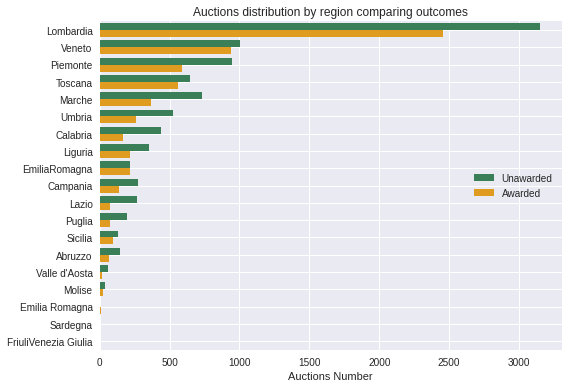

In [ ]:
ax = sns.countplot(data=df_raw,
                   y='regione',
                   hue='esito',
                   hue_order=[0, 1],
                   order=df_raw['regione'].value_counts().index,
                   palette=['seagreen', 'orange']
)
ax.set(xlabel='Auctions Number',
       ylabel='',
       title='Auctions distribution by region comparing outcomes'
)
plt.grid(True)
plt.legend(labels=['Unawarded', 'Awarded'])
plt.tight_layout()
plt.savefig("Numero aste per Regione e per Esito.png")
plt.show()

### Plotting Numero Aste per Mese e per Esito



In [ ]:
print('Numero aste per Mese e per Esito: ')
print(pd.crosstab(index=df['esito'], columns=df['data_asta'].dt.month_name()))

Numero aste per Mese e per Esito: 
data_asta  April  August  December  ...  November  October  September
esito                               ...                              
0            764      40       387  ...       611      804       1067
1              4       0      1056  ...      1188     1342        719

[2 rows x 12 columns]


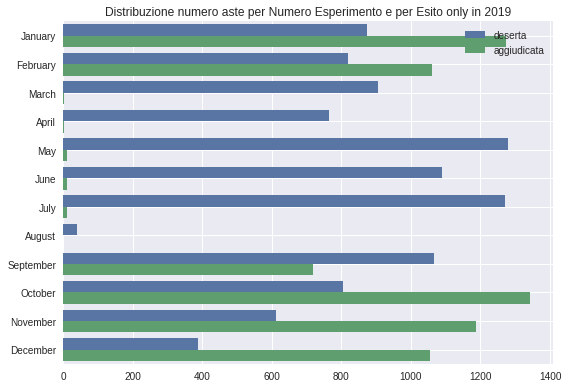

In [ ]:
ax = sns.countplot(data = df,
                   y = df['data_asta'].dt.month_name(),
                   hue = 'esito',
                   order= ['January', 'February', 'March', 'April','May','June','July', 'August', 'September', 'October', 'November','December']
)
 
ax.set(xlabel='',
      	 ylabel='',
       title="Distribuzione numero aste per Numero Esperimento e per Esito only in 2019"
)
plt.grid(True)
plt.legend(labels=['deserta', 'aggiudicata'])
plt.tight_layout()
plt.savefig("Numero aste per Mese e per Esito.png")
plt.show()


## Experiment Number

### Plotting Auction Distribution by Experiment Number

In [ ]:
print('Numero Aste per Esito: ')
print(df['numero_esperimento'].value_counts())

Numero Aste per Esito: 
1    4429
2    3025
3    1889
4    1050
5     626
6     347
7     222
8     109
9      67
Name: numero_esperimento, dtype: int64


numero_esperimento mean: 2.43 | numero_esperimento std: 1.66


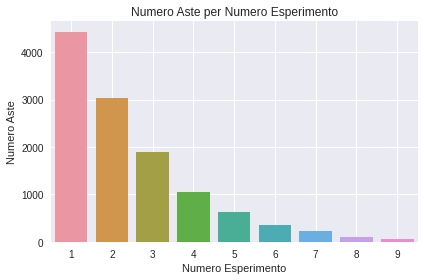

In [ ]:
print("numero_esperimento mean: %.2f | numero_esperimento std: %.2f"
      % (df['numero_esperimento'].mean(), df['numero_esperimento'].std()))

ax = sns.countplot(data=df, x='numero_esperimento')
ax.set(xlabel="Numero Esperimento",
       ylabel='Numero Aste',
       title="Numero Aste per Numero Esperimento"
)
plt.grid(True)
plt.tight_layout()
plt.savefig("Numero aste per Numero Esperimento.png")
plt.show()

###Plotting Auction Distribution by Experiment Number comparing outcomes

In [ ]:
print('Numero aste per numero_esperimento e per Esito: ')
print(pd.crosstab(index = df['esito'], columns = df['numero_esperimento']))

Numero aste per numero_esperimento e per Esito: 
numero_esperimento     1     2     3    4    5    6    7   8   9
esito                                                           
0                   2852  1763  1019  647  393  198  138  75  44
1                   1658  1255   858  401  229  153   67  41  23


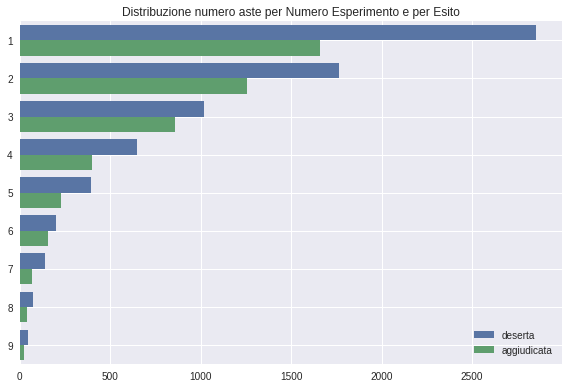

In [ ]:
ax = sns.countplot(data=df,
                   y='numero_esperimento',
                   hue='esito',
                   order=[i for i in range(1, np.max(df['numero_esperimento'])+1)]
)
ax.set(xlabel='',
       ylabel='',
       title='Distribuzione numero aste per Numero Esperimento e per Esito'
)
plt.grid(True)
plt.legend(labels=['deserta', 'aggiudicata'])
plt.tight_layout()
plt.savefig("Numero aste per Numero Esperimento e per Esito.png")
plt.show()

### Plotting Price Distribution by Experiment Number comparing outcomes

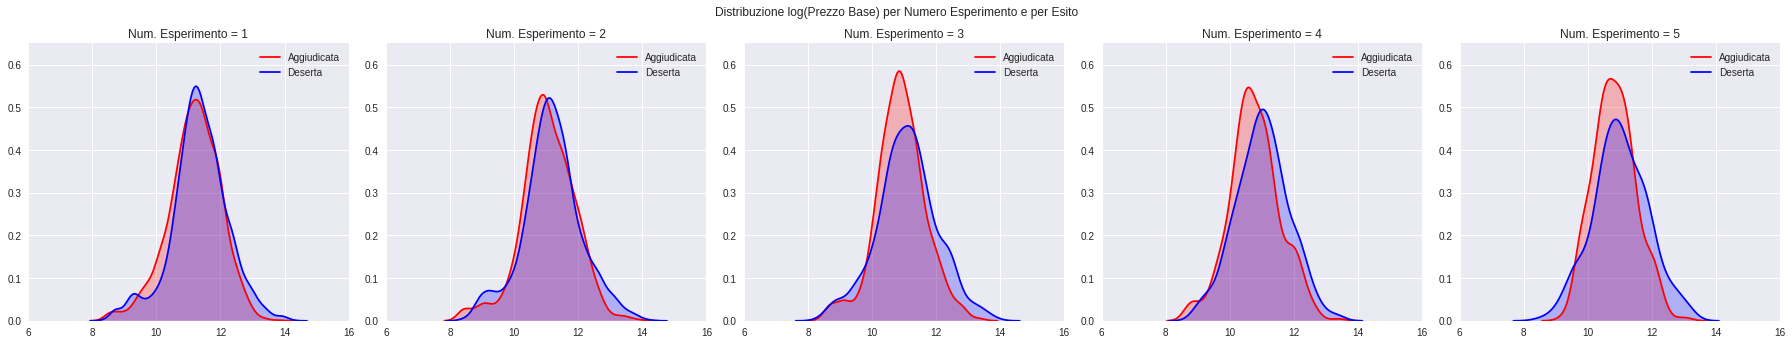

In [ ]:
fig = plt.figure(figsize = (25, 5))
for i in range(1, 6):
    ax = fig.add_subplot(1, 5, i)
    sns.kdeplot(df.loc[(df['numero_esperimento'] == i) & (df['esito'] == 1), 'prezzo_base_log'],
                color='r',
                shade=True,
                Label='Aggiudicata'
                )
    sns.kdeplot(df.loc[(df['numero_esperimento'] == i) & (df['esito'] == 0), 'prezzo_base_log'],
                color='b',
                shade=True,
                Label='Deserta')
    ax.set(title="Num. Esperimento = {}".format(i),
           xlim=(6, 16),
           ylim=(0, 0.65)
           )
    ax.grid(True)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Distribuzione log(Prezzo Base) per Numero Esperimento e per Esito")
plt.savefig("Distribuzione log(Prezzo Base) per Numero Esperimento e per Esito.png")

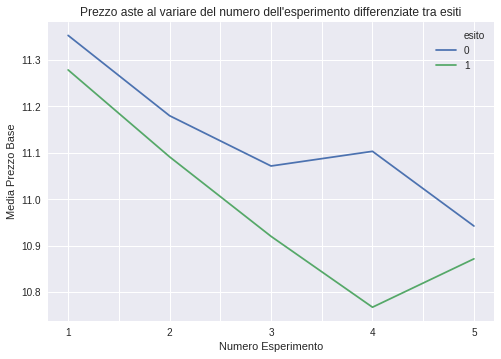

In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(x = 'numero_esperimento', y = 'prezzo_base_log',
            data = df.groupby(['numero_esperimento', 'esito'], as_index=False)['prezzo_base_log'].mean(),
            hue = 'esito',
            color='tomato')

_ = ax.set(title="Prezzo aste al variare del numero dell'esperimento differenziate tra esiti",
          xlabel = 'Numero Esperimento',
          ylabel = 'Media Prezzo Base',
          xticklabels = ['', 1, '', 2,'', 3,'', 4,'', 5],
          Label = ['Deserta', 'Aggiudicata'])
ax.grid(True)

## Liquidity

###Plotting Liquidity comparing outcomes

In [ ]:
print('Numero aste per liquidity e per Esito: \n')
print(pd.crosstab(index = df['esito'], columns = df['liquidity']))

Numero aste per liquidity e per Esito: 

liquidity    1     2     3     4
esito                           
0          827  2066  1966  2217
1          273  1166  1333  1916


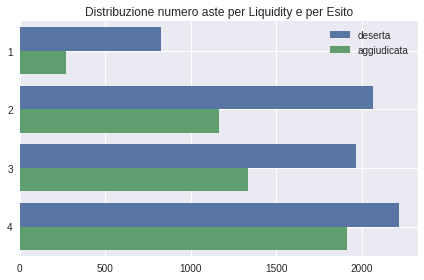

In [ ]:
ax = sns.countplot(data=df,
                   y='liquidity',
                   hue='esito',
)
ax.set(xlabel='',
       ylabel='',
       title='Distribuzione numero aste per Liquidity e per Esito'
)
plt.grid(True)
plt.legend(labels=['deserta', 'aggiudicata'])
plt.tight_layout()
plt.savefig("Distribuzione numero aste per Liquidity e per Esito.png")
plt.show()

### Plotting NTN distribution comparing outcomes

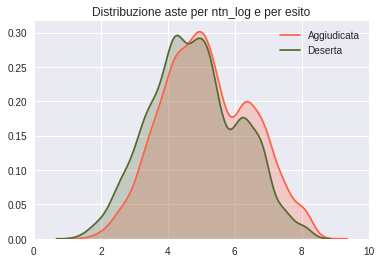

In [ ]:
fig, ax = plt.subplots()
ax = sns.kdeplot(df.loc[df['esito'] == 1 , 'ntn_totale_log'],
            color='tomato',
            shade=True,
            Label='Aggiudicata')

ax = sns.kdeplot(df.loc[df['esito'] == 0 , 'ntn_totale_log'],
            color='darkolivegreen',
            shade=True,
            Label='Deserta')

_ = ax.set(title="Distribuzione aste per ntn_log e per esito", xlim = (0, 10))
ax.grid(True)

### Violin Plotting NTN comparing outcomes

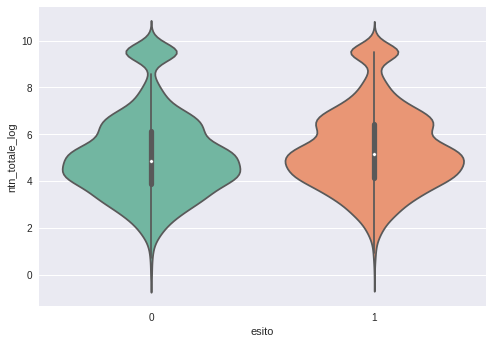

In [ ]:
# violin plot or box plot of log(ntn_totale) by esito
ax = sns.violinplot(y=df['ntn_totale_log'], x=df['esito'], data=df, palette="Set2")

### Plotting Price Distribution by Liquidity level comparing outcomes

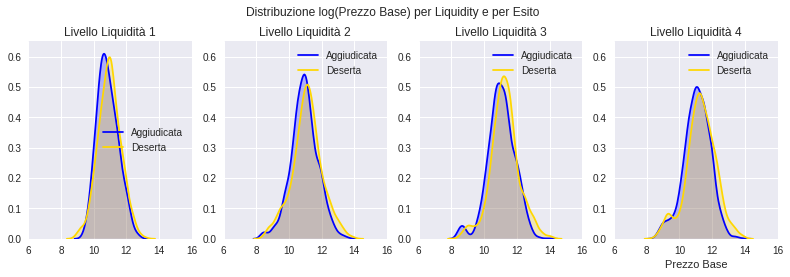

In [ ]:
fig = plt.figure(figsize = (11, 4))
for i in range(1, 5):
    ax = fig.add_subplot(1, 4, i)
    sns.kdeplot(df.loc[(df['liquidity'] == i) & (df['esito'] == 1), 'prezzo_base_log'],
                color='b',
                shade=True,
                Label='Aggiudicata'
                )
    sns.kdeplot(df.loc[(df['liquidity'] == i) & (df['esito'] == 0), 'prezzo_base_log'],
                color='gold',
                shade=True,
                Label='Deserta')
    ax.set(title=f'Livello Liquidità {i}',
           xlim=(6, 16),
           ylim=(0, 0.65)
           )
    ax.grid(True)
plt.xlabel('Prezzo Base')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Distribuzione log(Prezzo Base) per Liquidity e per Esito")
plt.savefig("Distribuzione log(Prezzo Base) per Liquidity e per Esito.png")

## Price

### Plotting Price Distribution

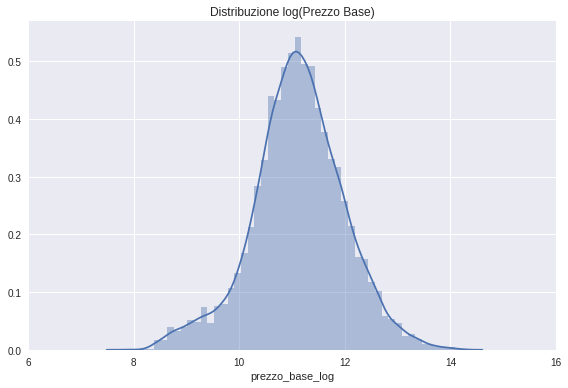

In [ ]:
sns.distplot(a=df['prezzo_base_log'])
plt.grid(True)
plt.title("Distribuzione log(Prezzo Base)")
plt.xlim(6, 16)
plt.tight_layout()
plt.savefig("Distribuzione log(Presso Base).png")

### Price Line plot across Experiments comparing outcomes

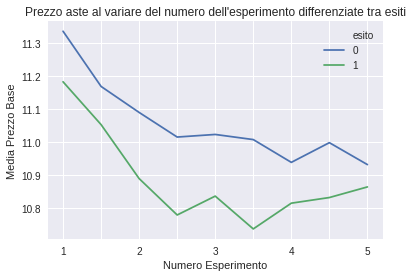

In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(x = 'numero_esperimento', y = 'prezzo_base_log',
            data = df.groupby(['numero_esperimento', 'esito'], as_index=False)['prezzo_base_log'].mean(),
            hue = 'esito')

ax.set(title="Prezzo aste al variare del numero dell'esperimento differenziate tra esiti",
          xlabel = 'Numero Esperimento',
          ylabel = 'Media Prezzo Base',
          xticklabels = ['', 1, '', 2,'', 3,'', 4,'', 5],
          Label = ['Deserta', 'Aggiudicata'])
ax.grid(True)

### Plotting Price Distribution By NTN comparing outcomes

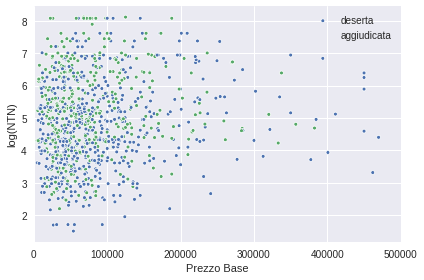

In [ ]:
ax = sns.scatterplot(data=df.sample(1000),
                   x='prezzo_base',
                   y='ntn_totale_log',
                   hue='esito',
                   size='esito',
                   sizes=[15, 15]
)
ax.set(xlabel='Prezzo Base',
       ylabel='log(NTN)',
       xlim=(0, 500000)
)
plt.grid(True)
plt.legend(labels=['deserta', 'aggiudicata'])
plt.tight_layout()
plt.savefig("Scatter plot prezzo base vs NTN.png")
plt.show()

### Plotting Price by NTN and Experiment Number comparing outcomes

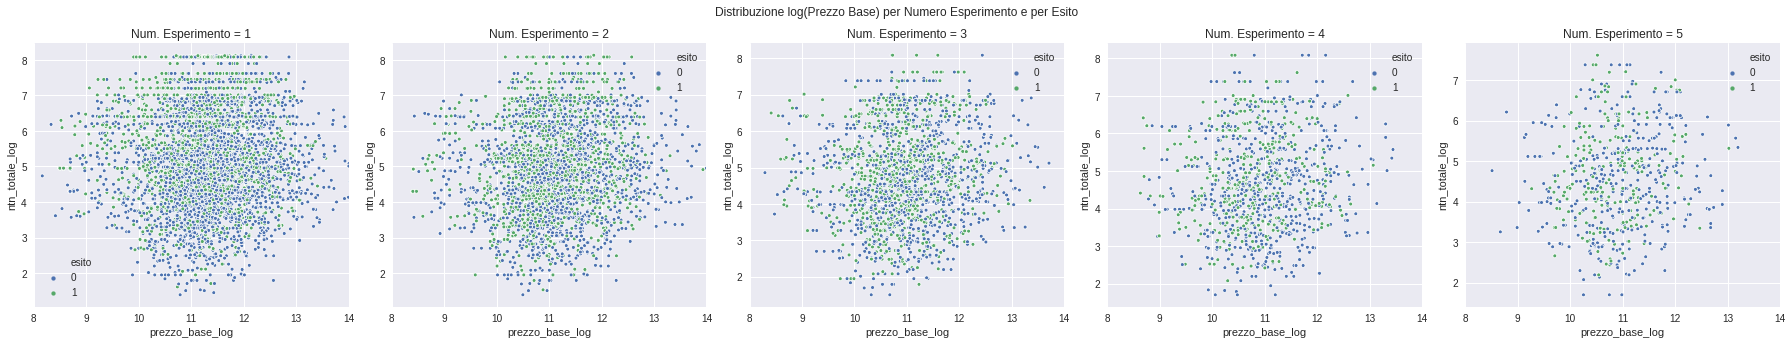

In [ ]:
fig = plt.figure(figsize = (25, 5))
for i in range(1, 6):
    ax = fig.add_subplot(1, 5, i)
    sns.scatterplot(data=df[df['numero_esperimento'] == i],
                   x='prezzo_base_log',
                   y='ntn_totale_log',
                   hue='esito',
                   size='esito',
                   sizes=[15, 15]
                    )
    ax.set(title="Num. Esperimento = {}".format(i), xlim = (8, 14))
    ax.grid(True)
  
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Distribuzione log(Prezzo Base) per Numero Esperimento e per Esito")
plt.savefig("Distribuzione log(Prezzo Base) per Numero Esperimento e per Esito.png")

### Plotting Price Distribution across different categories

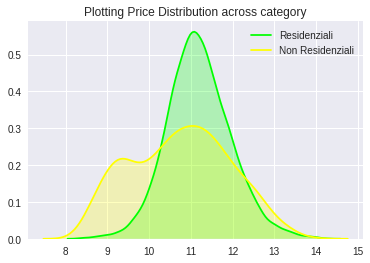

In [ ]:
fig, ax = plt.subplots()
ax = sns.kdeplot(df.loc[df['categoria'] == 1 , 'prezzo_base_log'],
            color='lime',
            shade=True,
            Label='Residenziali')

ax = sns.kdeplot(df.loc[df['categoria'] == 0 , 'prezzo_base_log'],
            color='yellow',
            shade=True,
            Label='Non Residenziali')

_ = ax.set(title="Plotting Price Distribution across category")
ax.grid(True)

## Discount

### Plotting Discount distribution comparing outcomes

Text(0.5, 0.98, 'Discount Distributions comparing outcomes')

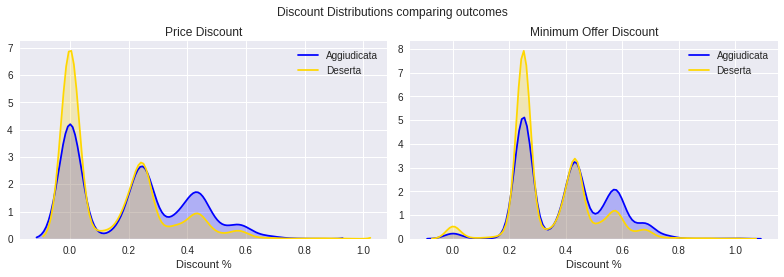

In [ ]:
fig = plt.figure(figsize = (11, 4))
sconto = [None, 'sconto', 'sconto_offmin']
titles = [None, 'Price Discount', 'Minimum Offer Discount']

for i in range(1, 3):
    ax = fig.add_subplot(1, 2, i)
    sns.kdeplot(df.loc[df['esito'] == 1, sconto[i]],
                color='b',
                shade=True,
                Label='Aggiudicata'
                )
    sns.kdeplot(df.loc[df['esito'] == 0, sconto[i]],
                color='gold',
                shade=True,
                Label='Deserta')
    ax.set(title=titles[i],
           xlabel = 'Discount %'
           )
    ax.grid(True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Discount Distributions comparing outcomes")

###Plotting Discounts by Experiment Number

## Correlation analysis

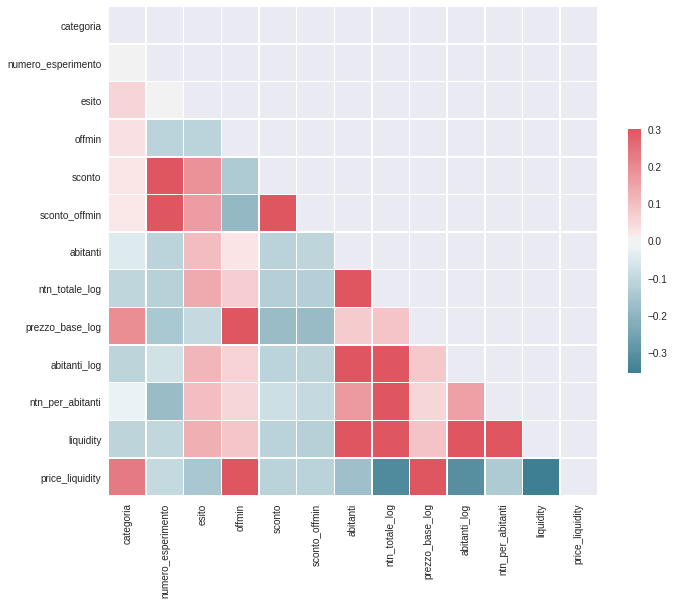

In [ ]:
corr = df_corr.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df_corr.corr()

,numero_esperimento,esito,ntn_totale_log,prezzo_base_log
numero_esperimento,1.000000,0.110605,-0.165449,-0.203299
esito,0.110605,1.000000,0.071745,-0.078693
ntn_totale_log,-0.165449,0.071745,1.000000,0.058205
prezzo_base_log,-0.203299,-0.078693,0.058205,1.000000


No handles with labels found to put in legend.


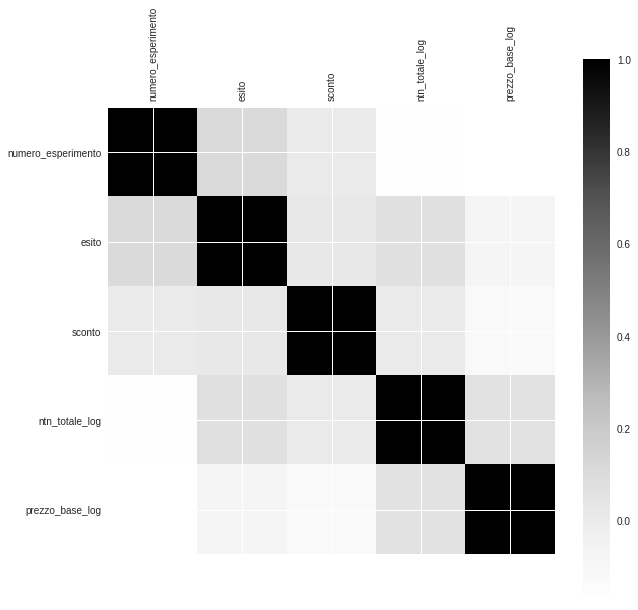

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.legend()
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    
plot_corr(df_corr)

# ML Model Design


## Train Test Split

In [ ]:
df.head()

,id,categoria,regione,provincia,comune,data_aggiudicata,data_asta,prezzo_base,numero_esperimento,esito,offmin,sconto,sconto_offmin,abitanti,ntn_totale
0,b1607915,1,Veneto,Verona,VERONELLA,2019-02-07,2019-02-07,123000.0,1,1,92250.0,0.00,0.2500,4670.0,73.66
1,b1608071,0,Veneto,Vicenza,TRISSINO,2019-03-06,2019-03-06,337500.0,6,0,253125.0,0.00,0.2500,8620.0,67.47
2,b1608110,1,Veneto,Vicenza,VICENZA,2019-03-06,2019-03-06,57800.0,1,1,43350.0,0.00,0.2500,111500.0,1338.44
3,b1608523,0,Veneto,Verona,VERONA,2019-02-14,2018-09-20,500000.0,1,0,375000.0,0.00,0.2500,252520.0,3359.30
4,b1608523,0,Veneto,Verona,VERONA,2019-02-14,2018-11-22,375000.0,2,0,281250.0,0.25,0.4375,252520.0,3359.30


In [ ]:
# We remove the label values from our training data
X = df.drop(['id', 'provincia', 'comune', 'data_aggiudicata', 'data_asta', 'esito'], axis=1).values
# We assigned those label values to our Y dataset
y = df['esito'].values

# Split it to a 70:30 Ratio Train:Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0, shuffle=True, stratify=y)

from sklearn.model_selection import learning_curve
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, 
                                                            X=X, 
                                                            y=y,
                                                            random_state=0, 
                                                            cv=5, 
                                                            train_sizes=np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.style.use('seaborn')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    plt.legend()
    return plt.show()

In [ ]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8
0,1,TrentinoAlto Adige,190000,1,142500,0,0.25,NaN,NaN
1,1,Lombardia,74000,1,55500,0,0.25,71128,757.34
2,0,Lazio,5000,3,3750,0.312177,0.484133,1277,10.5
3,1,TrentinoAlto Adige,51000,3,38250,0.271429,0.453571,NaN,NaN
4,1,Piemonte,82000,1,61500,0,0.25,872367,13508.3
...,...,...,...,...,...,...,...,...,...
10511,1,Piemonte,38000,1,28500,0,0.25,872367,13508.3
10512,1,Veneto,453000,1,339750,0,0.25,7297,59.4
10513,1,Piemonte,41000,2,30750,0.244936,0.433702,872367,13508.3
10514,1,Lombardia,66000,1,49500,0,0.25,3031,21.27


##Impute missing values of Trentino with Marche

In [ ]:
mean_ntn_marche = np.nanmean(np.array(X_train[X_train[:,1] == 'Marche',8], float))
mean_abitanti_marche = np.nanmean(np.array(X_train[X_train[:,1] == 'Marche',7], float))
print(mean_ntn_marche, mean_abitanti_marche)

from sklearn.impute import SimpleImputer

ntn_imp = SimpleImputer(strategy = 'constant', fill_value = mean_ntn_marche)
ab_imp = SimpleImputer(strategy = 'constant', fill_value = mean_abitanti_marche)

X_train[:,8] = ntn_imp.fit_transform(X_train[:,8].reshape(-1, 1)).reshape(-1)
X_test[:,8] = ntn_imp.transform(X_test[:,8].reshape(-1, 1)).reshape(-1)

X_train[:,7] = ab_imp.fit_transform(X_train[:,7].reshape(-1 , 1)).reshape(-1)
X_test[:,7] = ab_imp.transform(X_test[:,7].reshape(-1, 1)).reshape(-1)

217.91960380348655 24148.484944532487


##Adding Liquidity - Which are the best bins for cutting?

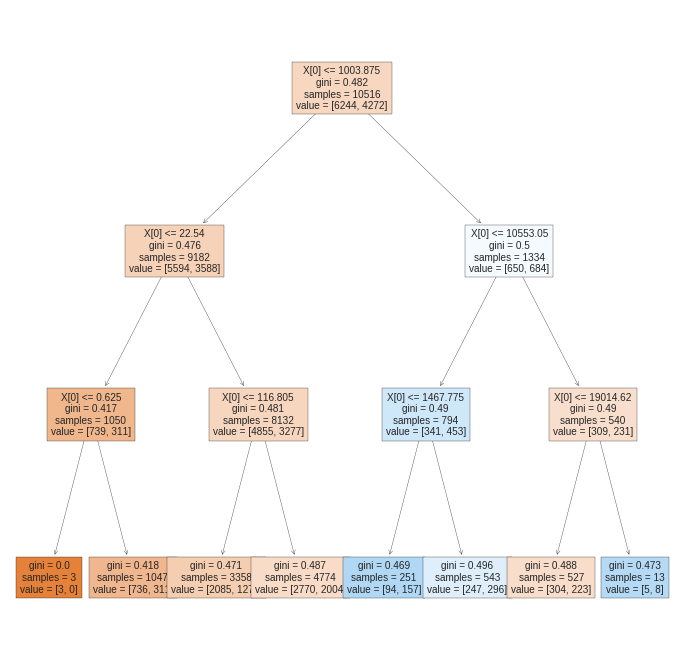

In [ ]:
dt = DecisionTreeClassifier(random_state=0, max_depth=3)
from sklearn import tree

dt.fit(X_train[:,8].reshape(-1, 1), y_train)
fig, ax = plt.subplots(figsize=(12, 12))

tree.plot_tree(dt, filled = True, fontsize=10)
plt.show()

In [ ]:
#train_test = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)], axis = 0)
#train_test['liquidity'] = pd.cut(train_test[8], bins = [-np.inf, 0.625, 116.805, 1467.775, 19014.62, np.inf], labels = False)
#train_test = pd.get_dummies(data=train_test, columns=['liquidity'], drop_first=True)
#X_train = train_test.iloc[:10516]
#X_test = train_test.iloc[10516:]
X_train = np.delete(np.array(X_train), 1, axis = 1)
X_test = np.delete(np.array(X_test), 1, axis = 1)

## Outlier Detection with Isolation Forest on full dataframe

In [ ]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7
0,1,190000,1,142500,0,0.25,24148.5,217.92
1,1,74000,1,55500,0,0.25,71128,757.34
2,0,5000,3,3750,0.312177,0.484133,1277,10.5
3,1,51000,3,38250,0.271429,0.453571,24148.5,217.92
4,1,82000,1,61500,0,0.25,872367,13508.3
...,...,...,...,...,...,...,...,...
10511,1,38000,1,28500,0,0.25,872367,13508.3
10512,1,453000,1,339750,0,0.25,7297,59.4
10513,1,41000,2,30750,0.244936,0.433702,872367,13508.3
10514,1,66000,1,49500,0,0.25,3031,21.27


In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, max_features = 3, max_samples=1500)
eliminate_train = clf.fit_predict(X_train)
eliminate_test = clf.predict(X_test)

print(f'Outliers detected are: {sum(eliminate_train == -1)}')
X_train = X_train[eliminate_train != -1, :]
y_train = y_train[eliminate_train != -1]
X_test = X_test[eliminate_test != -1, :]
y_test = y_test[eliminate_test != -1]

print(f'Train Dataframe Length: {X_train.shape[0]}')

Outliers detected are: 1018
Train Dataframe Length: 9498


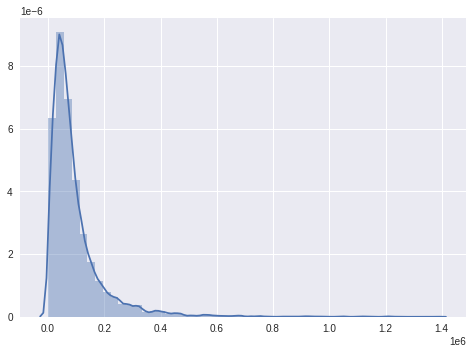

In [ ]:
sns.distplot(a=X_train[:,1])

In [ ]:
mean_base = np.mean(X_train[:,1])
std_base = np.std(X_train[:,1])

mask = X_train[:,1] - mean_base <= 4 * std_base
X_train = X_train[mask, :]
y_train = y_train[mask]
mask = X_test[:,1] - mean_base <= 4 * std_base
X_test = X_test[mask, :]
y_test = y_test[mask]

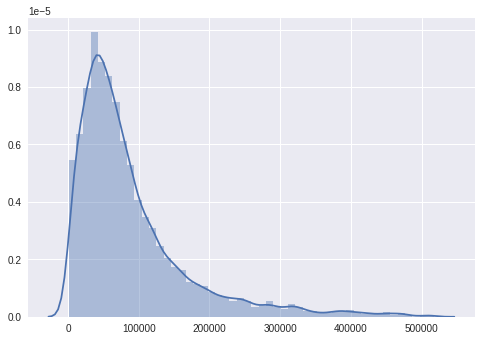

In [ ]:
sns.distplot(a=X_train[:,1])

##Polynomial Features

In [ ]:
pd.DataFrame(X_train)


,0,1,2,3,4,5,6,7
0,1,190000,1,142500,0,0.25,24148.5,217.92
1,1,74000,1,55500,0,0.25,71128,757.34
2,0,5000,3,3750,0.312177,0.484133,1277,10.5
3,1,51000,3,38250,0.271429,0.453571,24148.5,217.92
4,1,82000,1,61500,0,0.25,872367,13508.3
...,...,...,...,...,...,...,...,...
9388,1,38000,1,28500,0,0.25,872367,13508.3
9389,1,453000,1,339750,0,0.25,7297,59.4
9390,1,41000,2,30750,0.244936,0.433702,872367,13508.3
9391,1,66000,1,49500,0,0.25,3031,21.27


In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

#train = pd.DataFrame(X_train, columns=['cat1', 'num1', 'num2', 'num3','num4', 'num5', 'num6'] + [f'cat{i}' for i in range(2, 11)])
#test = pd.DataFrame(X_test, columns=['cat1', 'num1', 'num2', 'num3','num4', 'num5', 'num6'] + [f'cat{i}' for i in range(2, 11)])


pipeline = Pipeline([
    ('features', FeatureUnion([('num', 
                                Pipeline([('extract', 
                                           ColumnExtractor(columns=[f'num{i}' for i in range(1, 7)])),
                                          ('poly', 
                                           PolynomialFeatures(include_bias=False))  ])),
                               ('cat_var', 
                                ColumnExtractor(columns=[f'cat{i}' for i in range(1, 11)]))])
    )]) 

#pipeline.set_params(features__num__poly__degree=2)
#X_train = pipeline.fit_transform(train)
#X_test = pipeline.transform(test)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
X_tr = pf.fit_transform(X_train)
X_te = pf.transform(X_test)

## Scaling and PCA

In [ ]:
from sklearn.decomposition import PCA
scaling_pca = Pipeline([('scaling', MinMaxScaler()), ('pca', PCA())])
scaling_pca.fit_transform(X_tr)
explained_variance = np.cumsum(scaling_pca['pca'].explained_variance_ratio_) * 100
print(len(explained_variance))


45


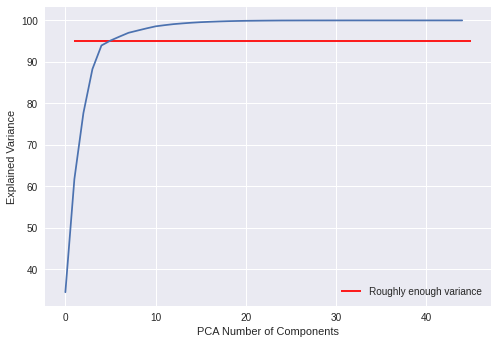

In [ ]:
sns.lineplot(x=np.arange(45), y=explained_variance)
plt.xlabel('PCA Number of Components')
plt.hlines(95,1,45, 'red', label = 'Roughly enough variance')
plt.ylabel('Explained Variance')
plt.legend()

## Choose 15 principal components for 100% explained variance

In [ ]:
pipeline = Pipeline([('pol', PolynomialFeatures(include_bias=False)), ('scaling', MinMaxScaler()), ('pca', PCA(15))])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [ ]:
import joblib
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [ ]:
train = pd.DataFrame(X_train)
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.113792,-0.605440,-0.272052,0.238560,-0.008060,0.121102,0.007604,0.041174,0.002363,-0.050745,-0.028173,-0.029160,-0.035709,-0.036689,0.003485
1,-0.149839,-0.544046,-0.083352,-0.184107,-0.003475,0.044614,-0.055738,-0.006302,0.019372,0.004767,0.044185,-0.019705,-0.024995,0.017051,-0.030119
2,-0.905744,0.909794,0.101105,-0.149216,-0.070122,0.143631,-0.012809,0.021857,-0.024495,-0.052468,-0.065119,0.043923,0.106193,0.027672,-0.003253
3,0.446794,0.068251,-0.013103,-0.171533,-0.011617,-0.069414,0.024354,0.000324,0.019019,-0.007316,-0.002070,0.038014,0.037234,0.000867,0.003936
4,-0.225015,-1.239915,2.623235,0.395126,0.092113,0.194456,0.060563,-0.507311,-0.010204,-0.133829,0.136810,0.049482,0.036439,0.005029,0.038820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9388,-0.227661,-1.155479,2.495652,0.165054,0.083505,0.098435,-0.012361,-0.346611,-0.015488,0.201515,-0.297629,0.006390,0.008813,-0.005111,-0.101734
9389,-0.042877,-0.815332,-0.602701,1.496028,-0.015681,0.358532,0.373363,0.206556,0.078492,0.064397,-0.186146,0.078625,0.035907,0.150406,0.027225
9390,0.199734,-0.836870,3.066172,0.335111,-0.136079,-0.325386,-0.065170,0.975912,0.019651,0.065291,0.003214,-0.048294,-0.055976,-0.016122,0.012960
9391,-0.148840,-0.504752,-0.205160,-0.239572,-0.008016,0.033005,-0.061627,0.005568,0.018453,0.042465,-0.000214,-0.023723,-0.027429,-0.000033,0.022211


## Logistic Regression

Parameters search that don't overfit - CV

In [ ]:
hyper_lr = {'C' : stats.uniform(0, 10), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}

In [ ]:
skf = StratifiedKFold(n_splits=5)
gs = RandomizedSearchCV(LogisticRegression(penalty='l2', max_iter=10000), hyper_lr, cv = skf, scoring = 'accuracy', n_jobs=-1, n_iter = 50)
gs.fit(X_train, y_train)
best_parameters_lr = gs.best_params_
print(best_parameters_lr)

{'C': 9.207013256318778, 'solver': 'lbfgs'}


Plot learning curve

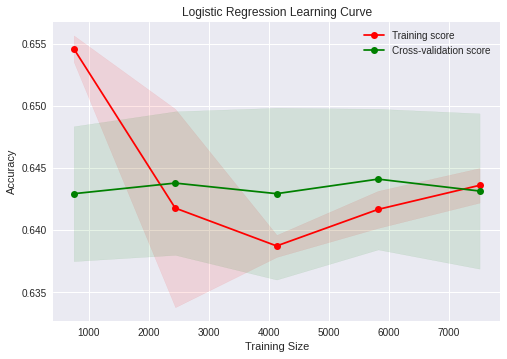

In [ ]:
plot_learning_curve(model = LogisticRegression(penalty='l2', max_iter=100000, C=best_parameters_lr['C'], solver=best_parameters_lr['solver'], random_state=0), X = X_train, y = y_train, title = 'Logistic Regression Learning Curve')

Fit the model with learned parameters

In [ ]:
model_lr = LogisticRegression(penalty='l2', max_iter=100000, C=best_parameters_lr['C'], solver=best_parameters_lr['solver'], random_state=0)
model_lr.fit(X_train, y_train)

LogisticRegression(C=9.207013256318778, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
predictions_lr = model_lr.predict(X_test)
print("Accuracy: {0:.2f}%".format(100*accuracy_score(predictions_lr, y_test)))

# score = model.score(X_test, y_test)
# print("Accuracy {0:.2f}%".format(100*score))

print("Confusion Matrix:")
print(confusion_matrix(predictions_lr, y_test))

print("Classification Report:")
print(classification_report(y_test, predictions_lr))

Accuracy: 63.36%
Confusion Matrix:
[[2076 1146]
 [ 333  482]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.74      2409
           1       0.59      0.30      0.39      1628

    accuracy                           0.63      4037
   macro avg       0.62      0.58      0.57      4037
weighted avg       0.62      0.63      0.60      4037



In [ ]:
print(pd.DataFrame({'Variables': df.drop(['esito'],axis=1).columns, 'Coefficients':model_lr.coef_[0]}))

ValueError: ignored

In [ ]:
print(model_lr.intercept_)

## Random Forest

Parameters search that don't overfit - CV

In [ ]:
# Number of features to consider at every split
max_features = [i for i in range(2, X.shape[1])]
# Maximum number of levels in tree
max_depth = [i for i in range(50, 200, 50)]
# Create the random grid
grid_random_forest = {'max_features': max_features,
                      'max_depth': max_depth,}
print(grid_random_forest)

{'max_features': [2, 3, 4, 5, 6, 7, 8], 'max_depth': [50, 100, 150]}


In [ ]:
gs = GridSearchCV(RandomForestClassifier(n_estimators=200, min_samples_leaf=5), grid_random_forest, cv = 5, scoring = 'accuracy')

gs.fit(X_train, y_train)
best_parameters_rf = gs.best_params_
print(best_parameters_rf)

{'max_depth': 50, 'max_features': 5}


Plot Learning curve

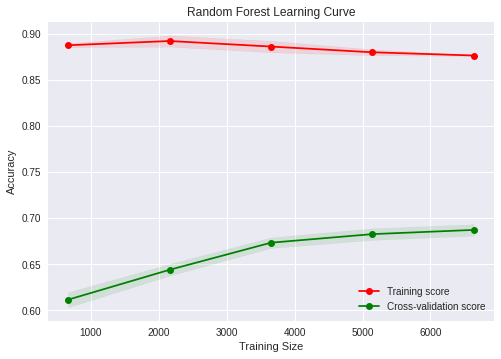

In [ ]:
plot_learning_curve(RandomForestClassifier(n_estimators=200, min_samples_leaf=5
                                           ,max_features = best_parameters_rf['max_features']
                                           ,max_depth = best_parameters_rf['max_depth'])
                    ,X_train
                    ,y_train
                    ,title = 'Random Forest Learning Curve')

Fit the model

In [ ]:
model_rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5
                                           ,max_features = best_parameters_rf['max_features']
                                           ,max_depth = best_parameters_rf['max_depth'])
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predictions_rf = model_rf.predict(X_test)
print("Accuracy: {0:.2f}%".format(100*accuracy_score(predictions_rf, y_test)))

print("Confusion Matrix:")
print(confusion_matrix(predictions_rf, y_test, labels=[1,0]))

print("Classification Report:")
print(classification_report(y_test, predictions_rf))

Accuracy: 64.31%
Confusion Matrix:
[[ 760  573]
 [ 868 1836]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      2409
           1       0.57      0.47      0.51      1628

    accuracy                           0.64      4037
   macro avg       0.62      0.61      0.62      4037
weighted avg       0.64      0.64      0.64      4037



In [ ]:
feature_importances_descending = pd.DataFrame(model_rf.feature_importances_,
                                   index = pd.DataFrame(X_train).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print("Feature importances from the most influential to the least influential: ")
feature_importances_descending

Feature importances from the most influential to the least influential: 


,importance
9,0.145725
4,0.105855
5,0.105816
1,0.105563
8,0.095372
2,0.094601
7,0.090637
0,0.089683
6,0.085932
3,0.080815


In [ ]:
print("Feature order as per df columns: ")
df.drop(['esito'],axis=1).columns

Feature order as per df columns: 


Index(['id', 'categoria', 'regione', 'provincia', 'comune', 'data_aggiudicata',
       'data_asta', 'prezzo_base', 'numero_esperimento', 'offmin', 'sconto',
       'sconto_offmin', 'abitanti', 'ntn_totale'],
      dtype='object')

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

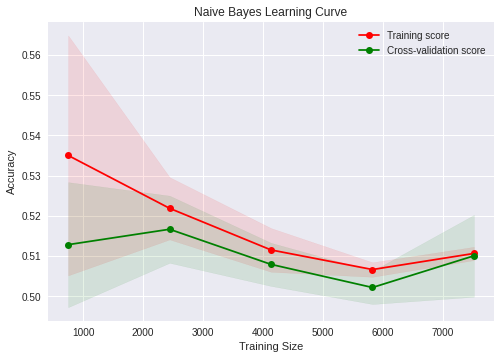

In [ ]:
plot_learning_curve(model_nb
                    ,X_train
                    ,y_train
                    ,title = 'Naive Bayes Learning Curve')

In [ ]:
predictions_nb = model_nb.predict(X_test)
print("Accuracy: {0:.2f}%".format(100*accuracy_score(predictions_lr, y_test)))

print("Confusion Matrix:")
print(confusion_matrix(predictions_lr, y_test, labels = [1,0]))

print("Classification Report:")
print(classification_report(y_test, predictions_lr))

Accuracy: 63.36%
Confusion Matrix:
[[ 482  333]
 [1146 2076]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.74      2409
           1       0.59      0.30      0.39      1628

    accuracy                           0.63      4037
   macro avg       0.62      0.58      0.57      4037
weighted avg       0.62      0.63      0.60      4037



##KNN

In [ ]:
hyper_knn = {'n_neighbors' : [2,3,4,5], 'weights': ['uniform', 'distance']}

In [ ]:
skf = StratifiedKFold(n_splits=5)
gs = GridSearchCV(KNeighborsClassifier(), hyper_knn, cv = skf, scoring = 'accuracy')
gs.fit(X_train, y_train)
best_parameters_knn = gs.best_params_
print(best_parameters_knn)

{'n_neighbors': 4, 'weights': 'uniform'}


In [ ]:
plot_learning_curve(model = KNeighborsClassifier(n_neighbors=best_parameters_knn['n_neighbors'], 
                                                 weights=best_parameters_knn['weights']),
                                                 X = X_train, 
                                                 y = y_train, 
                                                 title = 'KNN Learning Curve')

KeyboardInterrupt: ignored

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=best_parameters_knn['n_neighbors'], 
                                                 weights=best_parameters_knn['weights'])
model_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [ ]:
predictions_knn = model_knn.predict(X_test)
print("Accuracy: {0:.2f}%".format(100*accuracy_score(predictions_lr, y_test)))

print("Confusion Matrix:")
print(confusion_matrix(predictions_lr, y_test, labels = [1,0]))

print("Classification Report:")
print(classification_report(y_test, predictions_lr))

Accuracy: 63.36%
Confusion Matrix:
[[ 482  333]
 [1146 2076]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.74      2409
           1       0.59      0.30      0.39      1628

    accuracy                           0.63      4037
   macro avg       0.62      0.58      0.57      4037
weighted avg       0.62      0.63      0.60      4037



##Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
ensemble = StackingClassifier(estimators = (('Random Forest', model_rf),
                                            ('Naive Bayes', model_nb),
                                            ('KNN', model_knn)),
                              final_estimator = model_lr,
                              cv = 5)
ensemble.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=(('Random Forest',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=50,
                                                       max_features=5,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=5,
                                                       min_samples_split=2,
                                    

In [ ]:
plot_learning_curve(model = ensemble, X = X_train, y = y_train, title = 'Ensemble Learning Curve')

KeyboardInterrupt: ignored

In [ ]:
predictions_ens = ensemble.predict(X_test)
print("Accuracy: {0:.2f}%".format(100*accuracy_score(predictions_ens, y_test)))

print("Confusion Matrix:")
print(confusion_matrix(predictions_lr, y_test, labels = [1,0]))

print("Classification Report:")
print(classification_report(y_test, predictions_lr))

Accuracy: 65.54%
Confusion Matrix:
[[ 482  333]
 [1146 2076]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.74      2409
           1       0.59      0.30      0.39      1628

    accuracy                           0.63      4037
   macro avg       0.62      0.58      0.57      4037
weighted avg       0.62      0.63      0.60      4037



In [ ]:
from joblib import dump
dump(ensemble, 'Ex_Ante_ML.joblib') 

['Ex_Ante_ML.joblib']